# PROGETTO DEEP LEARNING



## Il Problema





"Buongiorno,

Il dataset è scaricabile a questo link: https://drive.google.com/file/d/16aLjqwrU-8erdTZ0tBo02_6m85RLy75E/view?usp=sharing
In allegato anche un file che spiega i punti di Repere che dobbiamo andare a localizzare.

Come possibile aiuto, guarderei qualche articolo su keypoint detection e pose estimation. Il nostro obiettivo è leggermente diverso ma la base è la stessa, dobbiamo localizzare dei punti specifici all'interno della immagine.
https://keras.io/examples/vision/keypoint_detection/
https://towardsdatascience.com/facial-keypoints-detection-image-and-keypoints-augmentation-6c2ea824a59
https://www.tensorflow.org/lite/examples/pose_estimation/overview
https://www.analyticsvidhya.com/blog/2021/10/human-pose-estimation-using-machine-learning-in-python/

L'idea è quella di implementare diverse reti, una per gruppo di punti, per predire le coordinate dei seguenti raggruppamenti (il numero indica l'indice nel file di testo)
0,1,4,5 (S,N,A,B)
2,3,7,8 (Sna, Snp, Gn, Go)
9,10,11,12 (U1 e L1 root e tip)
6,13 (pg, mesial)
Nel file di testo, ogni riga contiene l'indice del punto, alcune informazioni inutili, e le coordinate del punto (le ultime due colonne)

Eventualmente, se si ha tempo, confrontando i risultati con una rete che prova a predirli tutti insieme.

Eventualmente, se può servire potenza di calcolo maggiore si può pensare di chiedere accesso a Coka (https://www.fe.infn.it/coka/doku.php?id=start), il cluster di ateneo.

Mi sembra di non dimenticare nulla. Rimango a disposizione
Buon lavoro"
> Prof. Riccardo Zese

In [1]:
############################################################################
# IMPORTO LE LIBRERIE NECESSARIE
############################################################################
import numpy as np
import matplotlib.pyplot as plt

import os # per gestire files e cartelle, aprire il Dataset
import zipfile # per estrarre il Dataset

import random # per gestire un po' la casualita'

import pandas as pd # pandas
import seaborn as sns # seaborn

from matplotlib.cbook import boxplot_stats
from sklearn.model_selection import train_test_split # per fare lo split in DS di training e di test
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch  # Per il progetto uso PyTorch.
import torch.nn as nn  # Offre i vari layers per le RN e funzioni.
import torch.optim as optim  # Algoritmi di ottimizzazione.
import torch.nn.functional as F  # Per le funzioni di loss e anche per le funzioni di attivazione.
from torch.utils.data import Dataset, DataLoader  # Per importare il DS.

import torchvision.transforms as transforms  # Offre le principali trasformazioni per l'immagine.
import torchvision.models as models  # Modelli Pre-trained per task di vision tasks computer.

from tqdm import tqdm  # Provides progress bars during loops and iterations.
from PIL import Image  # Python Imaging Library for handling images.

ModuleNotFoundError: No module named 'tqdm'

## Importazione ed Estrazione del Dataset

In [ ]:
############################################################################
# Importazione ed Estrazione del Dataset
############################################################################

from google.colab import drive # Monto Google drive

# TODO: tutte le volte che ho un DS, è meglio collocarlo in Drive in una certa posizione e montarlo
#       poi, la prima cosa da fare sarà leggere il DS in un Dataframe di pandas.

drive.mount('/content/drive', force_remount=False) # Monto Google Drive a Colab
#############################################################################

# Verifico se esiste la directory in cui e' presente il mio DATASETS.
# Se presente, verifico che ci sia anche lo zip del DS
DATASET_DIR = '/content/drive/My Drive/DATASETS/'
DATASET_NAME_FILE = 'dataset_14_punti_pulito_06072023'
DATASET_NAME_FILE_ZIP = DATASET_DIR + DATASET_NAME_FILE + '.zip'

# Verifico che la directory esista
if os.path.exists( DATASET_DIR ):
    print("Directory trovata: ", DATASET_DIR)
    print("Contenuto della directory:", os.listdir( DATASET_DIR ) )

    # Verifico che il file zip esista
    if os.path.exists( DATASET_NAME_FILE_ZIP ):
        print("File zip del Dataset presente.")
    else:
        print("File zip del Dataset non trovato.")
else:
    print("Directory non trovata:", DATASET_DIR)

if 'dataset' not in os.listdir( DATASET_DIR ):
  # Estrazione del file: solo quando la cartella 'dataset' non e' gia' presente
  # TODO: questa operazione devo farla solo dopo aver montato Google Drive!
  with zipfile.ZipFile( DATASET_NAME_FILE_ZIP, 'r') as zip_ref:
      zip_ref.extractall( DATASET_DIR )
else:
  print("\nLa cartella e' gia' stata estratta dallo zip\n")

# Controllo del contenuto estratto
print( os.listdir( DATASET_DIR ) )

Mounted at /content/drive
Directory trovata:  /content/drive/My Drive/DATASETS/
Contenuto della directory: ['dataset_14_punti_pulito_06072023.zip', 'Piece_Dimension.csv', 'dataset']
File zip del Dataset presente.

La cartella e' gia' stata estratta dallo zip

['dataset_14_punti_pulito_06072023.zip', 'Piece_Dimension.csv', 'dataset']


## Analisi del Dataset



Per comprendere la struttura del dataset e prepararlo:

- Esploro le immagini: Verifica formato e dimensioni.
- Leggo i file di testo: Controllo come sono salvate le coordinate dei punti.


########################################
Numero di files totali: 3199
########################################


########################################
Numero files '.jpg' totali: 1599
########################################


########################################
Numero files '.txt' totali: 1599
########################################


########################################
Numero di eventuali altri files rimanenti: 1
########################################


########################################
Analisi dell'immagine numero: 826
########################################

Dimensioni immagine: (1026, 770)


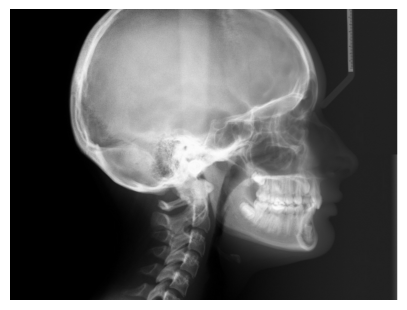


########################################
Analisi del relativo file di testo numero: 826
########################################

   Index  Area  Mean  Min  Max        X        Y
0      1     0   145  145  145  553.000  304.000
1      2     0    48   48   48  802.833  269.833
2      3     0   184  184  184  636.167  449.167
3      4     0    50   50   50  840.833  447.833
4      5     0    78   78   78  820.167  458.500

########################################
Statistiche riassuntive:
########################################

         Index  Area        Mean         Min         Max           X  \
count  14.0000  14.0   14.000000   14.000000   14.000000   14.000000   
mean    7.5000   0.0  120.571429  120.571429  120.571429  751.749929   
std     4.1833   0.0   62.466870   62.466870   62.466870   98.993220   
min     1.0000   0.0   22.000000   22.000000   22.000000  550.833000   
25%     4.2500   0.0   74.250000   74.250000   74.250000  731.666500   
50%     7.5000   0.0  115.500000  

In [ ]:
DATASET_PATH = DATASET_DIR + 'dataset' # dal precedente output vedo che il dataset si chiama 'dataset'

FILES = os.listdir( DATASET_PATH ) # lista di tutti i nomi dei files presenti dentro alla cartella in cui e' contenuto il dataset
NUM_TOTALE_FILES = len( ( FILES ) )  # conto gli elementi totali presenti dentro la cartella 'dataset'
print(f"\n########################################\nNumero di files totali: {NUM_TOTALE_FILES}\n########################################\n")

# Conto quanti files ".jpg" e ".txt" sono presenti
NUM_FILE_JPG = len ( list( filter( lambda nome_file : ( ".jpg" in nome_file), FILES ) ) )
NUM_FILE_TXT = len ( list( filter( lambda nome_file : ( ".txt" in nome_file ), FILES) ) )
NUM_OTHERS_FILES = NUM_TOTALE_FILES - ( NUM_FILE_JPG + NUM_FILE_TXT )
print(f"\n########################################\nNumero files '.jpg' totali: {NUM_FILE_JPG}\n########################################\n")
print(f"\n########################################\nNumero files '.txt' totali: {NUM_FILE_TXT}\n########################################\n")
print(f"\n########################################\nNumero di eventuali altri files rimanenti: {NUM_OTHERS_FILES}\n########################################\n")


n = random.randint(1, NUM_FILE_JPG)  # Numero casuale tra 1 e NUM_FILE_JPG (tanto i jpg sono collegati ai txt)
# n = 1237 # se provo a mettere n=1237 mi accorgo che non sono presenti l'img e il suo txt

#########################################################################
# Analisi di un'immagine campione e del relativo file di testo campione
#########################################################################

immagine_campione = os.path.join( DATASET_PATH, str(n)+'.jpg') # do il nome del path per trovare la singola immagine dentro il DS
sample_annotation = os.path.join( DATASET_PATH, str(n)+'.txt') # do il nome del path per trovare il singolo file di testo dentro il DS


if os.path.exists( immagine_campione ) and os.path.exists( sample_annotation ):
    try:
      print(f"\n########################################\nAnalisi dell'immagine numero: {n}\n########################################\n")
      img = Image.open( immagine_campione ) # apro ed identifico un file immagine usando PIL

      print(f"Dimensioni immagine: {img.size}")

      # Quindi provo a mostrarla con matplotlib (perchè con il modulo PIL non funziona qui su colab)
      plt.figure( figsize=(5, 5) )
      plt.imshow( img )
      plt.axis('off')  # Rimuove gli assi
      plt.show()


      print(f"\n########################################\nAnalisi del relativo file di testo numero: {n}\n########################################\n")
      # data = pd.read_csv(sample_annotation, delimiter=',', header=None) # Ho notato che la prima riga di ogni file di testo funge da intestazione
      data = pd.read_csv(sample_annotation, delimiter=',', header=0)    # pertanto con header=0 sto mettendo la prima riga del file come intestazione

      data.columns = ['Index', 'Area', 'Mean', 'Min', 'Max', 'X', 'Y']  # Colonne di un singolo file
      print( data.head() ) # stampo le prime 5 righe

      print("\n########################################\nStatistiche riassuntive:\n########################################\n")
      print( data.describe() )  # Statistiche riassuntive

      print("\n########################################\nMedia delle coordinate:\n########################################\n")
      print( data['X'].mean(), data['Y'].mean() )  # Media delle coordinate (lavoro per colonne)

    except Exception as e:
      print(f"Errore: {e}")
else:
    print(f"I file per il numero {n} non esistono.")

### Rimozione colonne inutili e verifica dati mancanti


In [ ]:
#########################################################################
# Stampare un Riepilogo del DataFrame (cioè del DS che ho caricato) uso il metodo data.info()
print("\nRiepilogo del dataframe:\n")
data.info()
#########################################################################

print("\n")
#########################################################################
# Rimozione delle colonne inutili
#########################################################################
data_cleaned = data.drop( ['Area', 'Mean', 'Min', 'Max'], axis=1 ) # Colonne inutili (come riportato nel testo dell'esercizio)

#########################################################################
# Controllo se ci sono valori mancanti, e nel caso rimuovo le righe
#########################################################################
missing_values = data_cleaned.isnull().sum()
print("\nValori mancanti in ogni colonna:\n", missing_values)

# Rimozione di righe con valori mancanti
data_cleaned = data_cleaned.dropna() # rimuovo i valori mancanti
print("\nDati puliti:\n", data_cleaned.head() )



Riepilogo del dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   14 non-null     int64  
 1   Area    14 non-null     int64  
 2   Mean    14 non-null     int64  
 3   Min     14 non-null     int64  
 4   Max     14 non-null     int64  
 5   X       14 non-null     float64
 6   Y       14 non-null     float64
dtypes: float64(2), int64(5)
memory usage: 916.0 bytes



Valori mancanti in ogni colonna:
 Index    0
X        0
Y        0
dtype: int64

Dati puliti:
    Index        X        Y
0      1  553.000  304.000
1      2  802.833  269.833
2      3  636.167  449.167
3      4  840.833  447.833
4      5  820.167  458.500


Molto bene, dell'output pare non presenti valori mancanti lungo ogni colonna.

Da rivedere bene l'analisi del Dataset !!!!

### Visualizzazione della distribuzione delle coordinate

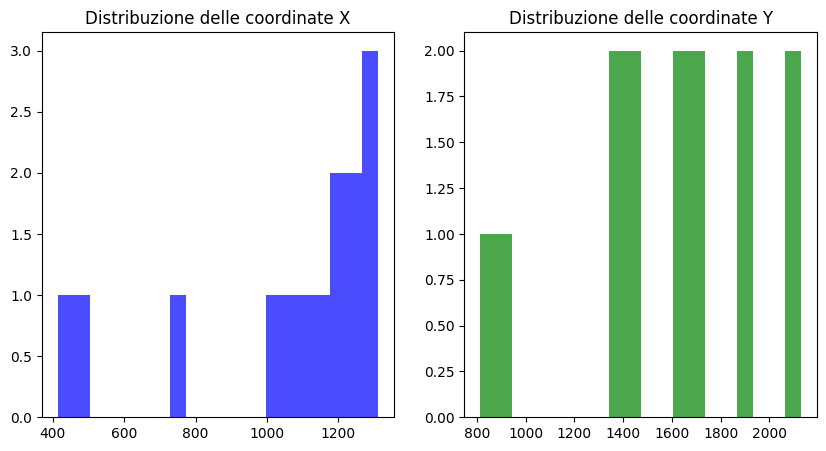

In [ ]:
plt.figure( figsize=(10, 5) )
plt.subplot(1,2,1)
plt.hist(data_cleaned['X'], bins=20, color='blue', alpha=0.7)
plt.title('Distribuzione delle coordinate X')


plt.subplot(1,2,2)
plt.hist(data_cleaned['Y'], bins=20, color='green', alpha=0.7)
plt.title('Distribuzione delle coordinate Y')
plt.show()

## Ulteriore studio
Ora provo a caricare e visualizzare alcune immagini insieme ai keypoints sovrapposti.

NOTA BENE: sto considerando nuovamente il dataset di partenza chiamato 'data'.


Analizzo immagine:826


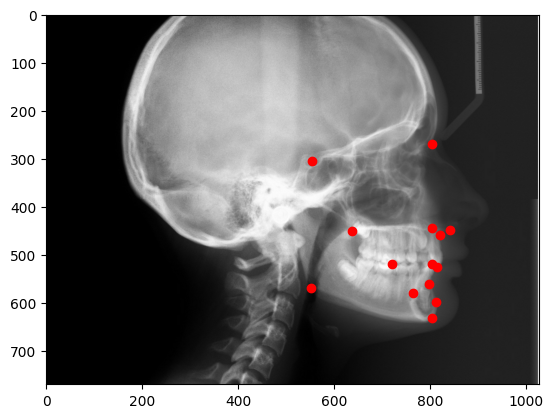

In [ ]:
import cv2 # importo cv2

print(f"\nAnalizzo immagine:{n}")

# Carica un'immagine e i relativi keypoints
# Sto ancora considerando data (il dataset di partenza) e non data_cleaned
image = cv2.imread( immagine_campione ) # sfrutto OpenCV
keypoints = [ (x, y) for x, y in zip( data['X'], data['Y'] )]  # Considero le colonne 'X' e 'Y' e prendo le coordinate (come delle coppie)

# Mostra l'immagine con i punti sovrapposti
plt.imshow( cv2.cvtColor( image, cv2.COLOR_BGR2RGB) )
for x, y in keypoints:
    plt.scatter(x, y, c='red')
plt.show()


Statistiche sui keypoints:

- Distribuzione delle coordinate: analizzo i valori delle coordinate X e Y per identificare eventuali anomalie.
- Distribuzione per gruppi: confronto i gruppi di punti come definito (0, 1, 4, 5; 2, 3, 7, 8 ecc.).



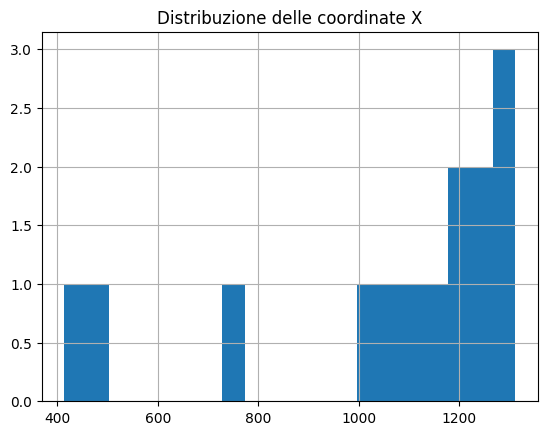

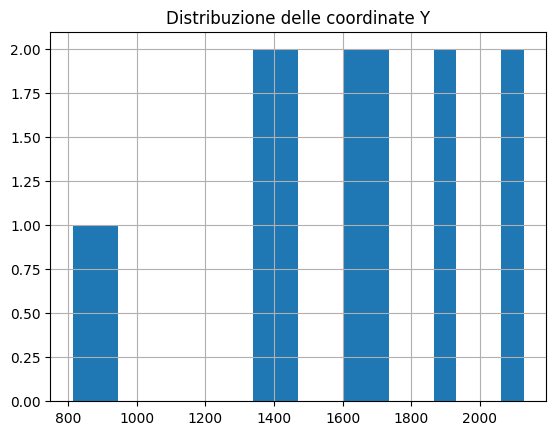

In [ ]:
# Istogrammi delle coordinate
# Ancora, sto usando il DS di partenza chiamato 'data' e non 'data_cleaned'
data['X'].hist( bins=20 )
plt.title('Distribuzione delle coordinate X')
plt.show()

data['Y'].hist( bins=20 )
plt.title('Distribuzione delle coordinate Y')
plt.show()

- Cerco outlier: keypoints con coordinate troppo grandi o negative.
- Valuta la completezza dei dati: ci sono punti mancanti?

In [ ]:
# Trova valori mancanti
print( data.isnull().sum() )

# Dimensioni dell'immagine
im = Image.open( immagine_campione ) # uso ancora PIL

w, h = im.size
print('width: ', w)
print('height:', h)

# Trova outlier nelle coordinate
x_outliers = data[ (data['X'] < 0) | ( data['X'] > w)]
y_outliers = data[ (data['Y'] < 0) | ( data['Y'] > h)]
print(f"Outlier nelle coordinate X: {len( x_outliers )}")
print(f"Outlier nelle coordinate Y: {len( y_outliers )}")

Index    0
Area     0
Mean     0
Min      0
Max      0
X        0
Y        0
dtype: int64
width:  1026
height: 770
Outlier nelle coordinate X: 0
Outlier nelle coordinate Y: 0


Correlazione tra punti
- Calcola la correlazione tra i gruppi di keypoints.
- Analizza la posizione relativa tra i punti, ad esempio la distanza tra il punto S e N.

In [ ]:
from scipy.spatial.distance import euclidean

# Calcola distanze tra punti specifici
distance_SN = euclidean( (data['X'][0], data['Y'][0]), (data['X'][1], data['Y'][1]) )
print(f"Distanza tra S e N: { distance_SN }")


Distanza tra S e N: 252.158505266033


Plotto più immagini con i keypoints per verificare visivamente la coerenza dei dati.

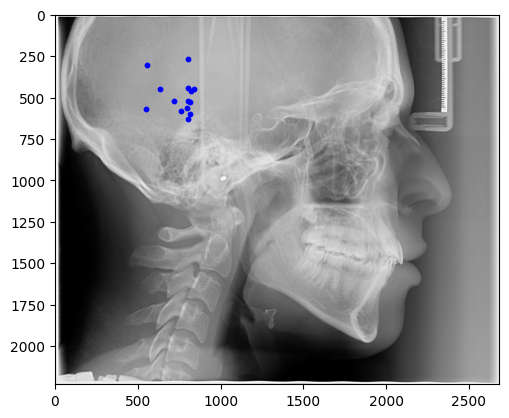

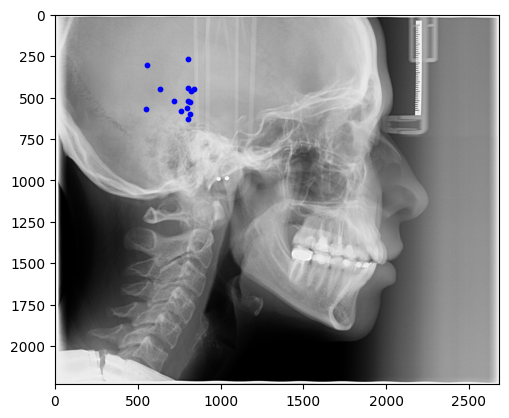

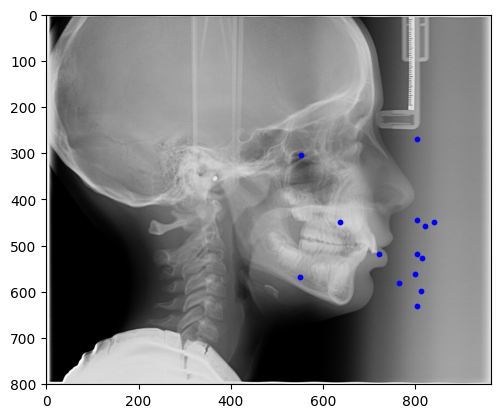

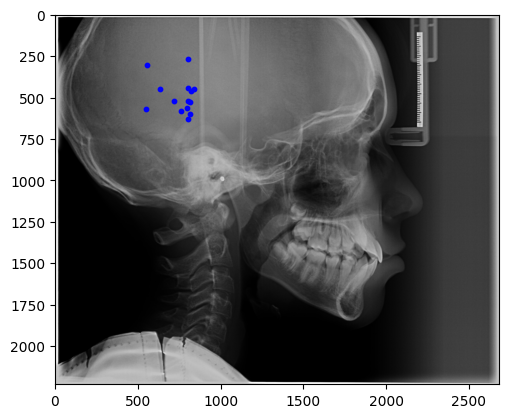

In [ ]:
def plot_image_with_keypoints(image_path, keypoints):
  '''
  Fa uso di OpenCV per assegnare un colore blu ai valori x ed y
  '''
  image = cv2.imread(image_path) # torno a processare l'immagine con OpenCV
  plt.imshow( cv2.cvtColor( image, cv2.COLOR_BGR2RGB) )
  for x, y in keypoints: # keypoints l'ho trovato prima
      plt.scatter(x, y, c='blue', s=10)
  plt.show()


# Itera su più immagini
for i in range(1, 5):  # Cambia il range per più immagini
    # print(f"PATH IMMAGINE: {DATASET_PATH}/{i}.jpg")
    plot_image_with_keypoints(f"{DATASET_PATH}/{i}.jpg", keypoints)

# NON MI CONVINCE L'OUTPUT: I PUNTI NON SONO DOVE VORREI ?? SONO CORRETTI ?? LO VERIFICO CON LE PROSSIME CELLE

Il risultato non mi convince...



Coordinate Keypoints e Sovrapposizione:
- Se le coordinate X e Y fornite nel file .txt sono corrette, i punti dovrebbero essere posizionati adeguatamente sull'immagine.

Correttezza dei Valori:
- Nel file .txt, i valori delle coordinate sembrano avere numeri grandi, compatibili con la dimensione dell'immagine (ad esempio, X=1288 e Y=660).

Correttezza della Funzione:
- La funzione plot_image_with_keypoints sembra funzionare correttamente, poiché i punti appaiono blu sull'immagine.
Tuttavia, bisogna verificare che:

  - I keypoints siano associati all'immagine giusta.
  - La scala delle coordinate corrisponda alla risoluzione dell'immagine.

In [ ]:
image_path = f"{DATASET_PATH}/1.jpg"
image = cv2.imread(image_path)
height, width = image.shape[:2]

# Verifica coordinate
keypoints_df = pd.read_csv(f"{DATASET_PATH}/1.txt", sep=',')

keypoints_df[['X', 'Y']] = keypoints_df[['X', 'Y']].astype(float)

invalid_points = keypoints_df[(keypoints_df['X'] > width) | (keypoints_df['Y'] > height)]

print(f"Punti non validi:\n{invalid_points}")

Punti non validi:
Empty DataFrame
Columns: [ , Area, Mean, Min, Max, X, Y]
Index: []


L'output `Empty DataFrame` indica che tutte le coordinate X e Y sono valide, ovvero rientrano nella dimensione dell'immagine fornita. Questo è un ottimo segnale e suggerisce che:

Le coordinate riportate nel file .txt corrispondono correttamente alla risoluzione dell'immagine (nessun punto si trova fuori dai limiti).

La tua funzione plot_image_with_keypoints dovrebbe posizionare correttamente i keypoints.



---


Possibili Verifiche Aggiuntive
- Anche se le coordinate sono valide, potresti voler confermare altri aspetti per garantire che tutto sia corretto:

Verifica Visiva dei Punti
- Controlla che i punti sull'immagine corrispondano effettivamente alle posizioni anatomiche che vuoi localizzare (ad esempio, punti cefalometrici come S, N, ecc.).

Calibrazione delle Dimensioni
- Se l'immagine è stata ridimensionata (ad esempio, compressa durante il caricamento o visualizzata in una scala diversa), i punti potrebbero non allinearsi visivamente.
- Usa OpenCV per confermare che la risoluzione dell'immagine originale corrisponde alle dimensioni attuali.

In [ ]:
print(f"Dimensioni immagine: larghezza={width}, altezza={height}")

Dimensioni immagine: larghezza=2685, altezza=2232
